# Projet 10 - Détecter des faux billets

## Sommaire

* [Analyse exploratoire des données](#chapter1)

    * [Import des modules et librairies](#section_1_1)
    * [Vérification et description des données](#section_1_2)
        * [Vérification des données](#section_1_2_1)
        * [Représentation des données](#section_1_2_2)
        
* [Analyse des prédictions](#chapter2)

    * [Imputation par régression linéaire](#section_2_1)
        * [Préparation des données](#section_2_1_1)
        * [Prédiction et résultats](#section_2_1_2)
        * [Analyse des résidus](#section_2_1_3)
        
    * [Analyse de la normalité](#section_2_2)
        * [Test de Shapiro](#section_2_2_1)
        * [Test de Kolmogorov-Smirnov](#section_2_2_2)
        * [Vérification de la normalité par Q-Q Plot](#section_2_2_3)

    * [Analyse des outliers](#section_2_3)        
            
    * [Analyse des Composantes Principales / Kmeans](#section_2_4)         
        * [Charges factorielles](#section_2_4_1)
        * [Clustering](#section_2_4_2)
        * [Analyse du pairplot](#section_2_4_3)
        * [Modélisation prédictive par Kmeans](#section_2_4_4)
            
    * [XGBoost](#section_2_5)         
        * [Modèle](#section_2_5_1)
        * [Analyse des distances de Cook](#section_2_5_2)
        * [Courbe ROC du XGBoost](#section_2_5_3)
        
    * [Régression logistique](#section_2_6)         
        * [Modèle](#section_2_6_1)
        * [Courbe ROC de régression logistique](#section_2_6_2)
            
* [Modèle final](#chapter3)

# Analyse exploratoire des données <a class="anchor" id="chapter1"></a>

## Importation des modules et librairies <a class="anchor" id="section_1_1"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from scipy.stats import zscore, shapiro, kstest

## Vérification et description des données <a class="anchor" id="section_1_2"></a>

### Vérification des données <a class="anchor" id="section_1_2_1"></a>

In [2]:
# import des données et head/tail
billets = pd.read_csv (r'C:\Users\Avenmythril\Desktop\Formations\DAn\Projet 10 - Python machine learning\billets.csv', delimiter=";")
billets

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95        4.52       2.89   
1           True    171.46       103.36        103.66        3.77       2.99   
2           True    172.69       104.48        103.50        4.40       2.94   
3           True    171.36       103.91        103.94        3.62       3.01   
4           True    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495       False    171.75       104.38        104.17        4.42       3.09   
1496       False    172.19       104.63        104.44        5.27       3.37   
1497       False    171.80       104.01        104.12        5.51       3.36   
1498       False    172.06       104.28        104.06        5.17       3.46   
1499       False    171.47       104.15        103.82        4.63       3.37   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1495  111.28  
1496  110.97  
1497  111.95  
1498  112.25  
1499  112.07  

[1500 rows x 7 columns]

In [3]:
# on effectue un describe sur le fichier
billets.describe()

diagonal  height_left  height_right   margin_low    margin_up  \
count  1500.000000  1500.000000   1500.000000  1463.000000  1500.000000   
mean    171.958440   104.029533    103.920307     4.485967     3.151473   
std       0.305195     0.299462      0.325627     0.663813     0.231813   
min     171.040000   103.140000    102.820000     2.980000     2.270000   
25%     171.750000   103.820000    103.710000     4.015000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.310000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

           length  
count  1500.00000  
mean    112.67850  
std       0.87273  
min     109.49000  
25%     112.03000  
50%     112.96000  
75%     113.34000  
max     114.44000

À première vue, il ne semble pas y avoir d'outliers. On repère cependant un count différent pour "margin_low", probablement 37 données manquantes à confirmer.

In [4]:
# on recherche les doublons
doublons = billets[billets.duplicated()]
print(doublons)

Empty DataFrame
Columns: [is_genuine, diagonal, height_left, height_right, margin_low, margin_up, length]
Index: []


Aucun doublon n'est à recenser.

In [5]:
# vérification de la quantité de données NaN
print(billets.isnull().sum())

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


Comme prévu, on retrouve bien 37 valeurs manquantes dans la colonne "marging_low".

### Représentation <a class="anchor" id="section_1_2_2"></a>

Jetons un premier coup d'oeil aux corrélations entre les différentes dimensions :

Text(0.5, 1.0, 'corrélations des variables')

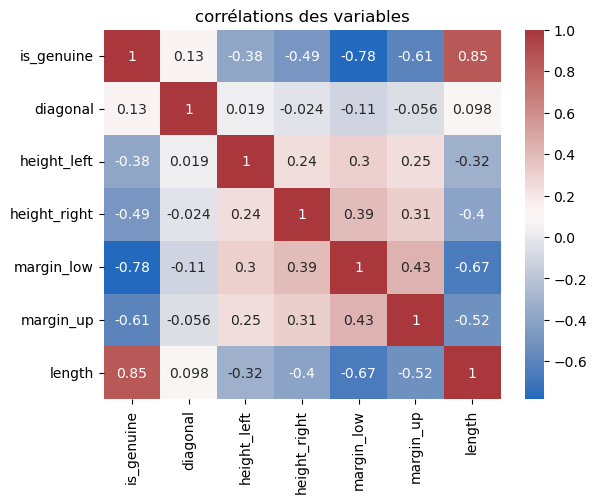

In [6]:
# heatmap de correlations
sns.heatmap(billets.corr(), cmap="vlag", annot=True).set_title('corrélations des variables')

Plusieurs informations ressortent directement :
- La longueur est fortement correlée à l'authenticité d'un billet, tandis que "margin_low" est particulièrement anticorrelée à l'authenticité.
- Une anticorrélation est justement visible entre la longueur et "margin_low".

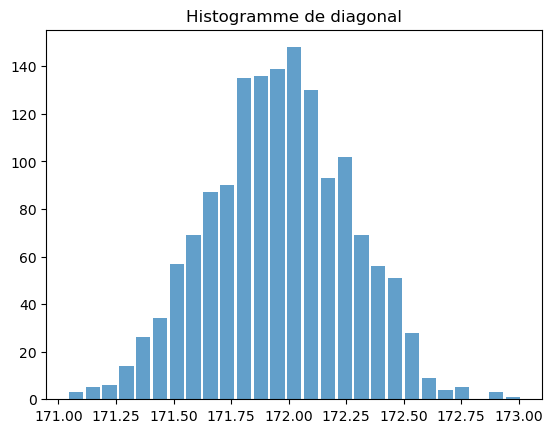

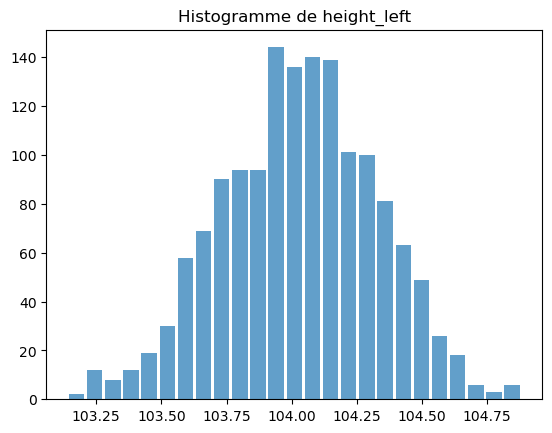

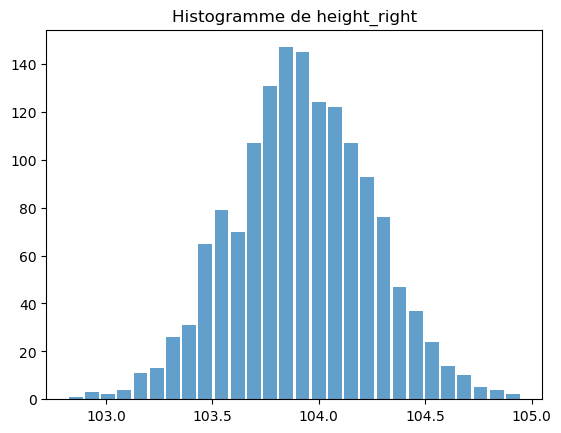

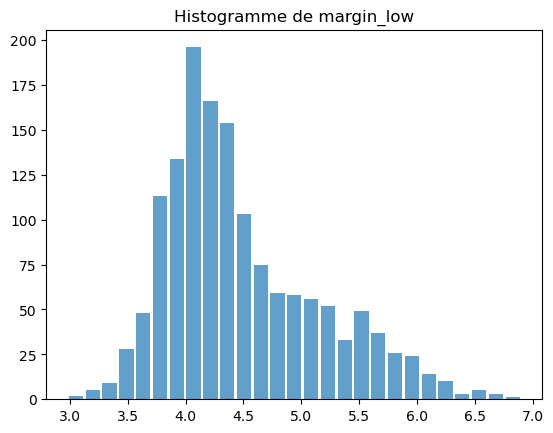

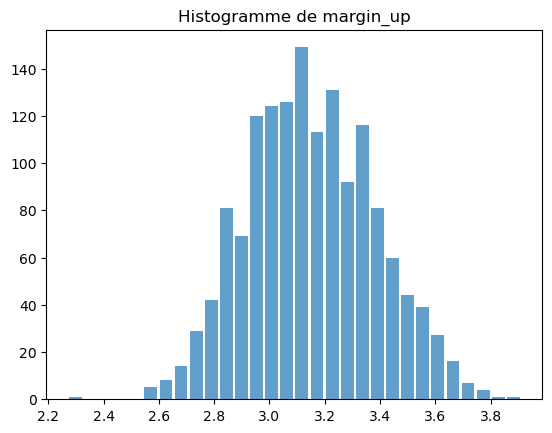

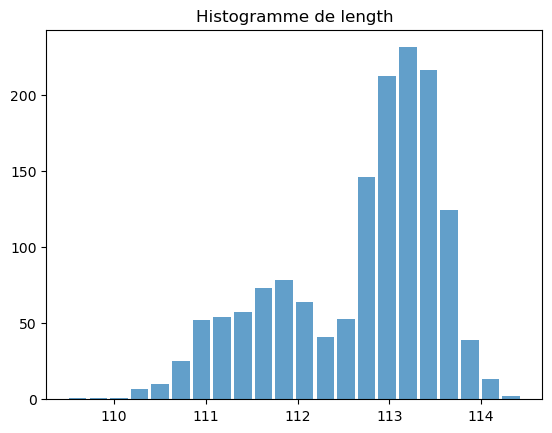

In [7]:
# préparation des colonnes à visualiser
columns_to_test = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

# affichage de l'histogramme
for column in columns_to_test:
    plt.hist(billets[column], bins='auto', alpha=0.7, rwidth=0.85)
    plt.title(f'Histogramme de {column}')
    plt.show()

On constate que les données semblent globalement <b>suivre la courbe gaussienne, mais pas complètement</b>. Nous allons vérifier cela après avoir géré les valeurs manquantes.

# Analyses des prédictions <a class="anchor" id="chapter2"></a>

## Imputation par régression linéaire <a class="anchor" id="section_2_1"></a>

### Préparation des données <a class="anchor" id="section_2_1_1"></a>

Plusieurs méthodes permettent de remplacer les valeurs manquantes, comme le remplacement par la médiane ou la moyenne. Dans notre cas, nous allons chercher à <b>prédire les données manquantes grâce à une régression linéaire</b>, qui permettra non seulement <b>d'être plus précis, mais aussi de commencer à analyser notre ensemble.

In [8]:
# on sépare les données avec des valeurs non manquantes et celles avec des valeurs manquantes
df_non_nan = billets.dropna(subset=['margin_low'])
df_nan = billets[billets['margin_low'].isnull()]

In [9]:
# on divise le df avec des valeurs non manquantes en features (X) et target (y)
X = df_non_nan.drop(['is_genuine', 'margin_low'], axis=1)
y = df_non_nan['margin_low']
# division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

À noter que l'on entraine sur margin_low car c'est la seule donnée où l'on a des variables manquantes, et parce qu'elle est particulièrement anticorrélée à l'authenticité. On ne prédit pas sur 'is_guenuine' car c'est une donnée binaire, le résultat ne serait pas optimal dans le cas de la régression linéaire.

In [10]:
# on standardise les données
standscal = StandardScaler()
X = standscal.fit_transform(X) 

### Prédiction et résultats <a class="anchor" id="section_2_1_2"></a>

In [11]:
# initialisation du modèle de régression linéaire
model = LinearRegression()
# entraînement du modèle
model.fit(X_train, y_train)
# on fait des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# et on évalue les performances du modèle
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.19144954947493328


Le Mean Squared Error (MSE) mesure la qualité du modèle de régression. Il est calculé comme la moyenne des carrés des écarts entre les valeurs prédites et les valeurs réelles. Plus il est bas, meilleure est la performance du modèle.
Une valeur de 0.19 révèle un modèle <b>relativement performant.

Accessoiremnent, nos données étant continues, le MSE remplace le classification report.

In [12]:
# on impute les valeurs manquantes avec les prédictions du modèle
X_impute = df_nan.drop(['is_genuine', 'margin_low'], axis=1)
predicted_margin_low = model.predict(X_impute)

# et on remplace les valeurs manquantes par les prédictions
billets.loc[billets['margin_low'].isnull(), 'margin_low'] = predicted_margin_low

In [13]:
r_squared = model.score(X_test, y_test)
print(f'R-squared: {r_squared}')

R-squared: 0.5457956683532408


Le R² indique une capacité de prédiction correcte de 54%, ce qui n'est <b>pas optimal. </b>Son fonctionnement permet d'expliquer les variations de notre variable "margin_low", qui était, pour rappel, fortement impactée par "is_guenuine".
Il se calcule de la sorte :

R² = 1 - (Somme des erreurs² / Somme totale des écarts²)

In [14]:
# vérification de l'imputation des valeurs manquantes
print(billets.isnull().sum())

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64


In [15]:
# on confirme les résultats par validation croisée (ou cross-validation)
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')

Cross-Validation Scores: [0.36432207 0.45283891 0.50452197 0.42619727 0.51908136]
Mean CV Accuracy: 0.45339231661583035


La moyenne de la cross-validation indique une <b>faible capacité de prédiction correcte</b> concernant ce modèle. Afin d'avoir plus de détails pour comprendre d'où viennent ces résultats mitigés, jetons un oeil au tableau OLS (Ordinary Least Square).

In [16]:
# ajout d'une colonne constante à la matrice X (nécessaire pour OLS)
X_with_const = sm.add_constant(X_train)

# initialisation du modèle OLS
ols_model = sm.OLS(y_train, X_with_const)

# on ajuste le modèle aux données
ols_results = ols_model.fit()

# affichage des résultats
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     198.7
Date:                Mon, 29 Jan 2024   Prob (F-statistic):          3.54e-153
Time:                        09:45:43   Log-Likelihood:                -825.58
No. Observations:                1170   AIC:                             1663.
Df Residuals:                    1164   BIC:                             1694.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           20.3960     11.266      1.810   

On distingue plusieurs informations:
- Le R² de l'OLS est aussi dans les environs de <b>50% de capacité de prédiction, donc insuffisant.
- Les coefficients ne mettent pas en avant une contribution importante de la part d'une donnée pour prédire.
- La p-value est inférieure à 0.05 pour toutes les données, excepté la diagonale, ce qui indique que <b>chaque autre variable est significative dans ce modèle pour essayer de prédire la variable dépendante.
- La f-stat nous informe que les données sont significatives dans l'ensemble, pas seulement quelques unes
- Entre 1.5 et 2.5, Durbin-Watson permet d'estimer qu'<b>il n'y a pas d'autocorrélation.

### Analyse des résidus <a class="anchor" id="section_2_1_3"></a>

La régression renvoie un certain nombre d'erreurs de prédictions, nommés aussi "résidus", que l'on peut considérer comme l'écart entre la valeur attendue et la valeur réelle/observée. Comprendre ces mauvaises prédictions est nécessaire pour ajuster notre modèle. Analysons cela.

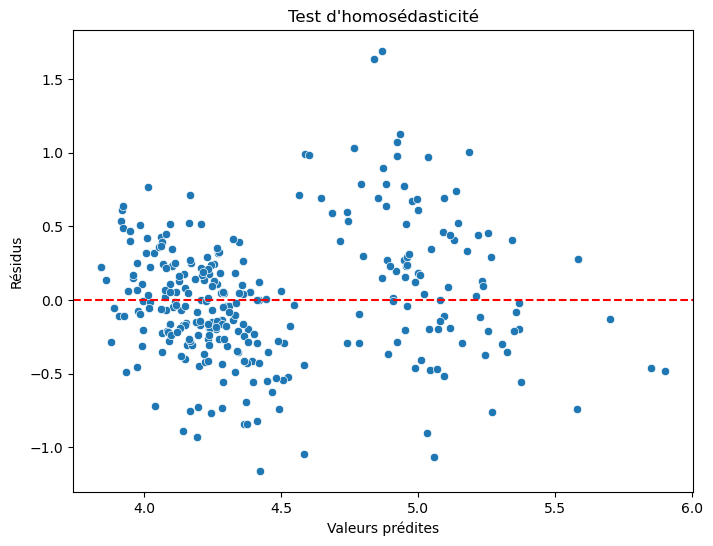

In [17]:
# on calcule les résidus
residuals = y_test - y_pred

# visualisation du graphique de dispersion des résidus
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Test d\'homosédasticité')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.show()

Le résultat est clair : les deux clusters que l'on peut distinguer indiquent <b>une hétérosédasticité</b>. Il nous faut analyser les données de manière plus poussée, avec les tests des résidus studentisés et celui des leviers.


Petites explications :
- Un <b>résidu studentisé</b> est un résidu ajusté en fonction de l'écart-type pour prendre en compte la variabilité naturelle des données. <b>Plus il est petit, plus la prédiction est proche de la réalité</b>. Cela permet de repérer les résidus ayant plus d'écart (et donc d'impact) par rapport à la tendance générale.
- Le test des leviers permet de révéler <b>les observations qui ont un impact sur l'ensemble du modèle</b>. Il est complémentaire des résidus studentisés.

In [18]:
# calcul des résidus studentisés
studentized_residuals = residuals / np.sqrt(metrics.mean_squared_error(y_test, y_pred))

# on affiche les résidus studentisés
print("Résidus Studentisés:")
print(studentized_residuals)

Résidus Studentisés:
1208    0.533336
178    -0.087721
281    -0.451904
561    -0.377761
891     0.519378
          ...   
1491    0.535523
493     0.035460
494    -0.089569
1080    1.399018
1326    2.457638
Name: margin_low, Length: 293, dtype: float64


In [19]:
# calcul des leviers
ols_influence = OLSInfluence(ols_results)
leverage = ols_influence.hat_matrix_diag

# affichage des leviers
print("Leviers:")
print(leverage)

Leviers:
[0.00725122 0.00418985 0.0055459  ... 0.00541211 0.00706353 0.00599925]


In [20]:
# seuils pour les leviers et les résidus studentisés
## Valeur de base : 2 * (nombre de caractéristiques + 1) / nombre d'observations
leverage_threshold = 2 * (X_train.shape[1] + 1) / X_train.shape[0]
studentized_residual_threshold = 2  # ce seuil est un hyperparamètre

# on identifie les observations avec des leviers élevés...
high_leverage_points = np.where(leverage > leverage_threshold)[0]

# ...ainsi que celles avec des résidus studentisés élevés
high_studentized_residuals_points = np.where(np.abs(studentized_residuals) > studentized_residual_threshold)[0]

# et on affiche le tout
print("Observations avec des leviers élevés:")
print(high_leverage_points)

print("Observations avec des résidus studentisés élevés:")
print(high_studentized_residuals_points)

Observations avec des leviers élevés:
[  12   26   30   49   93  119  127  141  155  182  227  240  246  259
  285  291  296  309  330  331  336  349  394  462  497  510  518  520
  524  545  555  566  598  602  618  631  643  652  664  696  707  745
  859  893  908  914  916  931  935  936  990 1019 1023 1038 1041 1074
 1103 1104 1120 1160]
Observations avec des résidus studentisés élevés:
[ 83  84  93 101 109 120 124 126 143 149 182 184 185 213 230 262 292]


Les résultats obtenus révèlent 60 leviers élevés pour 17 résidus studentisés par rapport à la variance globale du modèle. <b>Cela peut provenir d'une anormalité des données, que nous analyserons donc par la suite.

Distances de Cook pour chaque observation:
893     1.469827e-03
1071    4.825885e-07
260     3.203741e-03
1097    1.964298e-04
1224    1.806789e-03
            ...     
1161    1.407816e-03
1328    2.743299e-04
884     5.687057e-05
1496    1.613557e-04
1157    2.661591e-03
Length: 1170, dtype: float64
Observations influentes:
Int64Index([1422, 1284,  965,  292, 1199,  375, 1143, 1060,  182, 1369, 1036,
             664, 1254, 1087, 1191, 1163, 1348, 1198, 1042, 1480, 1134, 1329,
            1244, 1053, 1290, 1413, 1325, 1136, 1113, 1429, 1133, 1420, 1075,
            1450, 1478, 1223, 1426,  367,   52, 1181, 1457, 1361, 1027, 1359,
             243,  606,  924,  804, 1150, 1124,   80, 1110,  394, 1416, 1362,
            1253, 1228, 1022,  518,  897, 1333, 1321, 1353, 1195, 1245, 1459,
            1300, 1291, 1031, 1345, 1092, 1464, 1257, 1074, 1473, 1166, 1418,
            1090, 1185, 1355,  452, 1041, 1089, 1094,  577, 1186, 1372, 1367],
           dtype='int64')


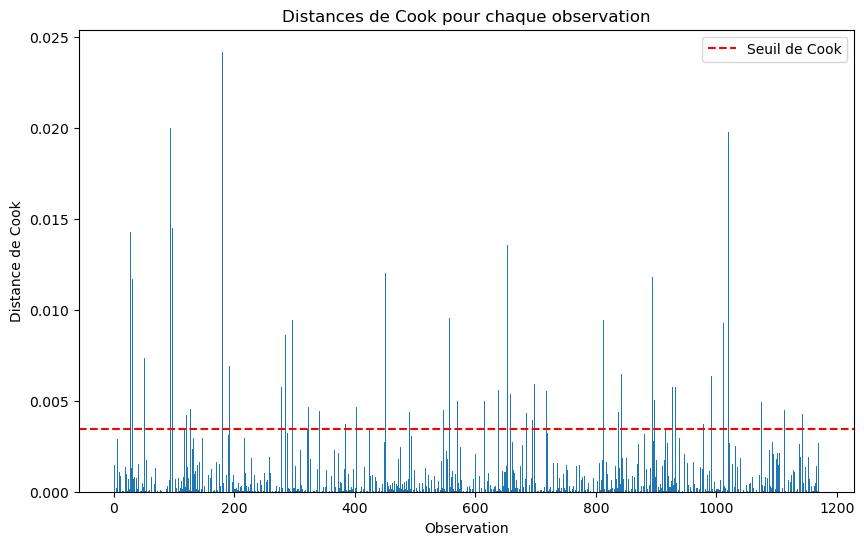

In [21]:
# préparation du modèle
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

# on reprend les leviers
influence = results.get_influence().summary_frame()
leviers = influence['hat_diag']

# calcul des distances de Cook
n, p = X_train.shape
cooks_distances = influence['cooks_d'] * (p + 1) / (p * (1 - leviers))

# seuil de Cook pour identifier les observations influentes
seuil_dcook = 4 / (n - p)

# affichage des distances de Cook
print("Distances de Cook pour chaque observation:")
print(cooks_distances)

# on identifie les observations influentes
observations_influentes = cooks_distances[cooks_distances > seuil_dcook].index

# affichage des observations influentes
print("Observations influentes:")
print(observations_influentes)

# visualisation du graphique de Cook
plt.figure(figsize=(10, 6))
plt.bar(range(1, n + 1), cooks_distances)
plt.axhline(y=seuil_dcook, color='red', linestyle='--', label='Seuil de Cook')
plt.title("Distances de Cook pour chaque observation")
plt.xlabel("Observation")
plt.ylabel("Distance de Cook")
plt.legend()
plt.show()

Cette visualisation montre le nombre et surtout l'importance de certaines influences sur le modèle. Peut-être aurons nous plus de chance avec un autre.

### Analyse de la linéarité et de la multicolinéarité

Comme nous venons de le voir, certaines valeurs ne sont pas prédites correctement, et plusieurs indicateurs permettent de le justifier. Pour comprendre ces écarts et trouver le modèle de prédiction le plus performant, il nous faut creuser plus profondément et comprendre ce qui peut (ou pas) relier les données entre elles.

La multicolinéarité et la linéarité sont des concepts qui peuvent justifier les résultats obtenus.

Petites explications :
- La linéarité permet d'observer la <b>relation entre les variables indépendantes et la variable dépendante</b> (dans notre cas "is_genuine")
- La multicolinéarité se concentre sur la <b>corrélation entre les variables indépendantes</b>. Par exemple, si deux variables sont correlées, il devient difficile de savoir laquelle contribue le plus au modèle.
- Étant donné que nous avons tenté une analyse de régression linéaire, le résultat attendu dans les prochaines visualisations devrait indiquer une linéarité, mais pas forcément une multicolinéarité ni son absence.

In [22]:
# définition des variables dépendantes et indépendantes
X = billets[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
y = billets['is_genuine']

# on ajoutez une constante à X car on utilise statsmodels
X = sm.add_constant(X)

# ajustement du modèle
reg_LM2 = sm.OLS(y, X).fit()

# on effectue le test de linéarité Rainbow
rainbow_stat, rainbow_p_value = linear_rainbow(reg_LM2)

# affichage des résultats
print(f'Statistique "Rainbow": {rainbow_stat}')
print(f'p-value: {rainbow_p_value}')

Statistique "Rainbow": 1.297179565276407
p-value: 0.00019448645930787335


Le <b>test de linéarité Rainbow</b> évalue l'hypothèse nulle selon laquelle la relation entre les variables indépendantes et dépendantes dans notre modèle est linéaire. Voici comment interpréter les résultats :

- La statistique "Rainbow" est la statistique du test de linéarité. Plus elle est grande, plus il y a d'évidence contre l'hypothèse de linéarité. Notre résultat n'est pas assez parlant et doit être complété par la p-value.
- p-value qui est cependant assez claire. Plus on s'approche de 0, plus on peut rejeter l'hypothèse de linéarité, ce qui est le cas ici.

Il nous faut continuer à chercher, puis partir sur un modèle de prédiction plus robuste, ou avec une approche différente.

Analysons maintenant la <b>multicolinéarité grâce au VIF</b>, ou Variance Inflation Factor.

In [23]:
# calcul des VIF pour chaque variable indépendante
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# affichage des résultats
print(vif_data)

       Variable            VIF
0         const  593791.524741
1      diagonal       1.017858
2   height_left       1.158732
3  height_right       1.260428
4    margin_low       1.936179
5     margin_up       1.419362
6        length       2.141482


Les résultats suggèrent que <b>la multicollinéarité n'est pas un problème majeur dans nos prédictions</b>, car il est inférieur à 10 (sinon, ce serait signe de forte multicollinéarité). De manière générale, en dessous de 5, c'est considéré comme acceptable.

À noter que "const" (ou constante) est généralement ignoré, car ce n'est pas une variable indépendante, et un VIF élevé pour la constante est courant.

## Analyse de la normalité <a class="anchor" id="section_2_2"></a>

### Test de Shapiro  <a class="anchor" id="section_2_2_1"></a>

Si les graphiques suivaient globalement une courbe Gaussienne, les résultats vus dans l'analyse de l'homosédasticité qui a suivi la régression linéaire remettent clairement en doute cette hypothèse. Afin de s'assurer de la normalité des valeurs, nous allons utiliser le <b>test de Shapiro-Wilks, qui fonctionne particulièrement bien sur les petits ensembles de données comme le notre.

In [24]:
# variables à tester
variables_to_test = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

# boucle de parcours des variables
for variable_name in variables_to_test:
    # sélction des variables
    variable_to_test = billets[variable_name]

    # test de Shapiro-Wilk
    stat, p_value = shapiro(variable_to_test)

    # affichage des résultats
    print(f"Variable : {variable_name}")
    print(f"Statistique de test : {stat}")
    print(f"P-value : {p_value}")

    # interprétation du résultat
    alpha = 0.05
    if p_value > alpha:
        print("Les données semblent suivre une distribution normale (on conserve l'hypothèse nulle)")
    else:
        print("Les données ne suivent pas une distribution normale (on rejette l'hypothèse nulle)")

    print("\n" + "="*50 + "\n")  # Juste pour séparer les résultats de chaque variable

Variable : diagonal
Statistique de test : 0.9986855387687683
P-value : 0.32343590259552
Les données semblent suivre une distribution normale (on conserve l'hypothèse nulle)


Variable : height_left
Statistique de test : 0.9979010820388794
P-value : 0.0509396530687809
Les données semblent suivre une distribution normale (on conserve l'hypothèse nulle)


Variable : height_right
Statistique de test : 0.9995179772377014
P-value : 0.9806053638458252
Les données semblent suivre une distribution normale (on conserve l'hypothèse nulle)


Variable : margin_low
Statistique de test : 0.9375225901603699
P-value : 1.2794130730565665e-24
Les données ne suivent pas une distribution normale (on rejette l'hypothèse nulle)


Variable : margin_up
Statistique de test : 0.9961656928062439
P-value : 0.000810406228993088
Les données ne suivent pas une distribution normale (on rejette l'hypothèse nulle)


Variable : length
Statistique de test : 0.9176009893417358
P-value : 7.863947037789753e-28
Les données ne

Le test révèle seulement <b>3 dimensions à distribution normale</b>. Essayons de confirmer avec une autre méthode.

### Test de Kolmogorov-Smirnov  <a class="anchor" id="section_2_2_2"></a>

In [25]:
alpha = 0.05  # niveau de signification (hyperparamètre)

for column in columns_to_test:
    # on applique le test à chaque colonne
    statistic, p_value = kstest(billets[column], 'norm')

    # affichage des résultats pour chaque colonne
    print(f'Statistique de test pour {column} : {statistic}')
    print(f'P-value pour {column} : {p_value}')

    # interprétation du test pour chaque colonne
    if p_value > alpha:
        print(f"Les données de {column} suivent une distribution normale (l'hypothèse n'est pas rejetée)\n")
    else:
        print(f"Les données de {column} ne suivent pas une distribution normale (l'hypothèse est rejetée)\n")

Statistique de test pour diagonal : 1.0
P-value pour diagonal : 0.0
Les données de diagonal ne suivent pas une distribution normale (l'hypothèse est rejetée)

Statistique de test pour height_left : 1.0
P-value pour height_left : 0.0
Les données de height_left ne suivent pas une distribution normale (l'hypothèse est rejetée)

Statistique de test pour height_right : 1.0
P-value pour height_right : 0.0
Les données de height_right ne suivent pas une distribution normale (l'hypothèse est rejetée)

Statistique de test pour margin_low : 0.99855875808266
P-value pour margin_low : 0.0
Les données de margin_low ne suivent pas une distribution normale (l'hypothèse est rejetée)

Statistique de test pour margin_up : 0.9940997251697775
P-value pour margin_up : 0.0
Les données de margin_up ne suivent pas une distribution normale (l'hypothèse est rejetée)

Statistique de test pour length : 1.0
P-value pour length : 0.0
Les données de length ne suivent pas une distribution normale (l'hypothèse est reje

Les résultats du test KS révèlent des <b>données anormales et contredit le premier test</b>, même si celui de Shapiro est plus robuste dans un petit ensemble. Essayons de visualiser la normalité avec une 3eme méthode.

### Vérification de la normalité par Q-QPlot  <a class="anchor" id="section_2_2_3"></a>

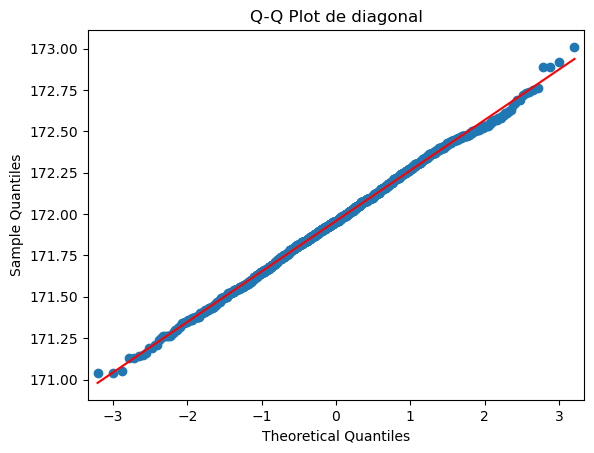

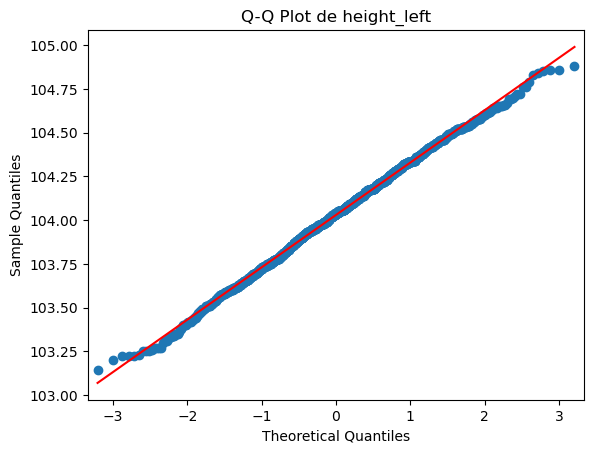

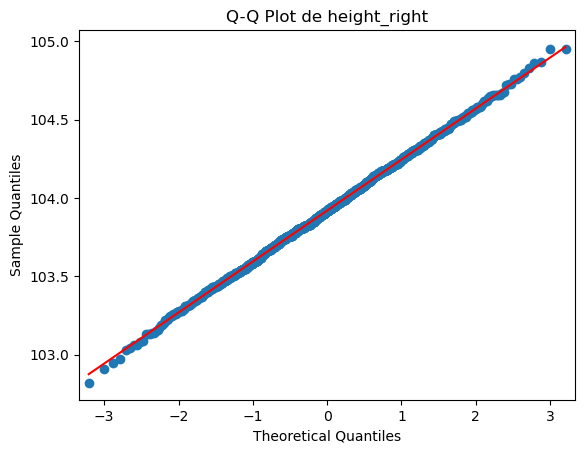

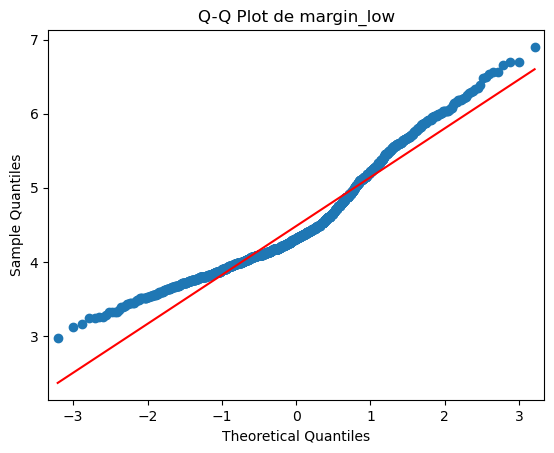

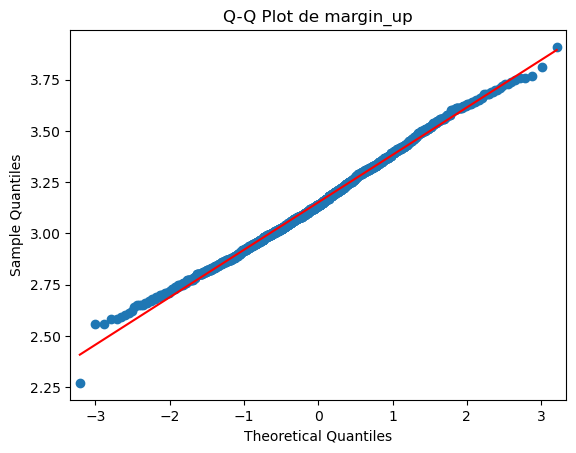

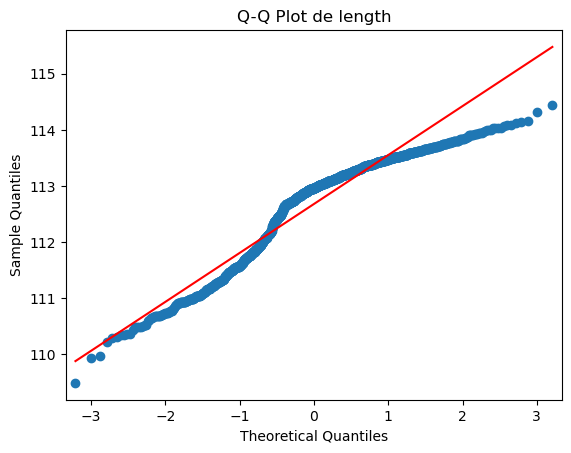

In [26]:
# visualisation du Q-Q plot
for column in columns_to_test:
    sm.qqplot(billets[column], line='s')
    plt.title(f'Q-Q Plot de {column}')
    plt.show()

Le graphique quantile-quantile (Q-Q plot) compare visuellement la distribution des données à une distribution théorique (comme la distribution normale) :
- Si les points sont alignés, nos données suivent la distribution théorique.
- Les écarts par rapport à la droite indiquent les différences. Une ligne inclinée peut d'ailleurs indiquer des écarts d'écart type mais nous n'avons pas le cas ici.

Concrètement, <b>4 données sont très proches d'une distribution normale, mais deux autres ("length" et "margin_low") divergent.</b> Cela coïncide avec le résultat de la matrice des corrélations et des histogrammes. Nous sommes proches de la normalité, mais quelques "écarts" poussent les modèles basés sur des valeurs normées à commettre des erreurs. Tentons une autre approche en analysant les outliers

## Analyse des outliers <a class="anchor" id="section_2_3"></a>

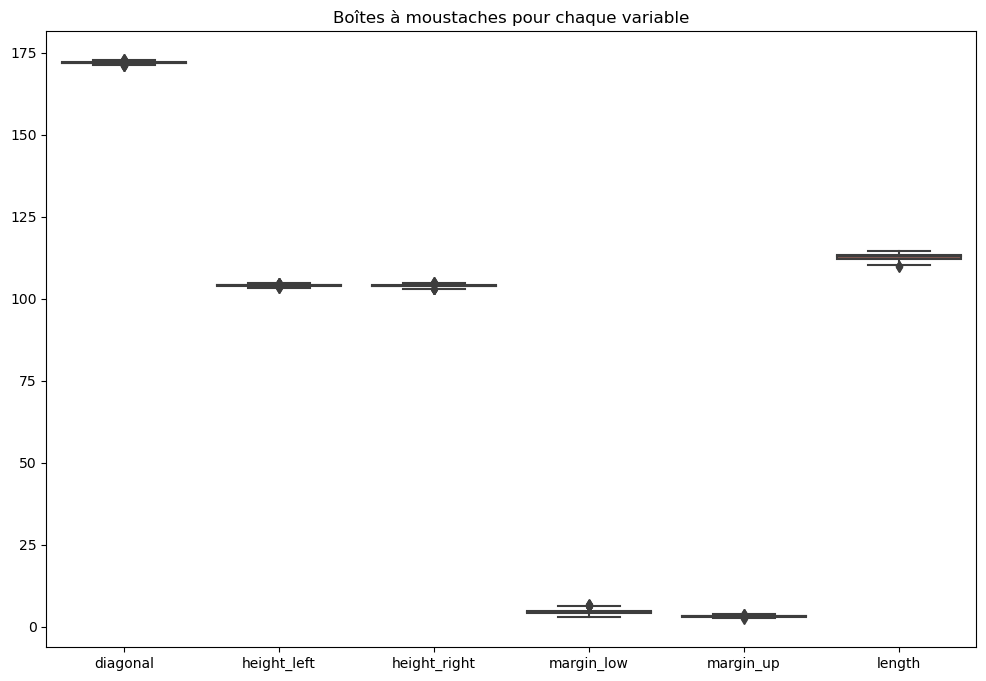

In [27]:
# boîtes à moustaches pour chaque variable
variables_kmeans = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
plt.figure(figsize=(12, 8))
sns.boxplot(data=billets[variables_kmeans])
# affichage des boxplots
plt.title('Boîtes à moustaches pour chaque variable')
plt.show()

In [28]:
# Détermination des outliers par z-score
# boucle pour compter le nombre total d'outliers
total_outliers = 0

# on ajoute une colonne pour indiquer si une observation est un outlier ou non
billets['is_outlier_zscore'] = 0

for variable in variables_kmeans:
    # calcul du z-score pour chaque observation
    z_scores = zscore(billets[variable])

    # on identifie les outliers basés sur un seuil de z-score (hyperparamètre : 3)
    outliers_zscore = np.abs(z_scores) > 3

    # mise à jour de la colonne is_outlier_zscore
    billets['is_outlier_zscore'] = np.where(outliers_zscore, 1, billets['is_outlier_zscore'])

    # on affiche les outliers par colonne
    print(f"Outliers (z-score) in {variable}: {billets.index[outliers_zscore].tolist()}")
    
    # mise à jour du compteur total d'outliers
    total_outliers += outliers_zscore.sum()

# affichage du résultat total
print(f"Le nombre total d'outliers (z-score) est de : {total_outliers}")

# affichage du nombre d'outliers par classe (True ou False)
print("Nombre d'outliers par classe (z-score):")
print(billets.groupby('is_genuine')['is_outlier_zscore'].sum())

Outliers (z-score) in diagonal: [729, 828, 842, 1022, 1142, 1277]
Outliers (z-score) in height_left: []
Outliers (z-score) in height_right: [0, 251, 522, 1484]
Outliers (z-score) in margin_low: [1027, 1041, 1110, 1124, 1169, 1254, 1290, 1441, 1464]
Outliers (z-score) in margin_up: [664, 1029]
Outliers (z-score) in length: [1082, 1355, 1453]
Le nombre total d'outliers (z-score) est de : 24
Nombre d'outliers par classe (z-score):
is_genuine
False    17
True      7
Name: is_outlier_zscore, dtype: int64


In [29]:
# Détermination des outliers par IQR
# boucle pour compter le nombre total d'outliers
total_outliers = 0

# ajout d'une colonne qui permettra de savoir si le billet est vrai ou non
billets['is_outlier'] = 0

for variable in variables_kmeans:
    q1 = billets[variable].quantile(0.25)
    q3 = billets[variable].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # identification des outliers
    outliers = (billets[variable] < lower_bound) | (billets[variable] > upper_bound)

    # remplacement des outliers par la médiane
    billets[variable] = np.where(outliers, billets[variable].median(), billets[variable])

    # mise à jour de la colonne is_outlier
    billets['is_outlier'] = np.where(outliers, 1, billets['is_outlier'])

    # on affiche les outliers par colonne
    print(f"Outliers in {variable}: {billets.index[outliers].tolist()}")
    
    # mise à jour du compteur total d'outliers
    total_outliers += outliers.sum()

# affichage du résultat total
print(f"Le nombre total d'outliers est de : {total_outliers}")
print("")

# affichage du nombre d'outliers par classe (True ou False)
print("Nombre d'outliers par classe:")
print(billets.groupby('is_genuine')['is_outlier'].sum())

Outliers in diagonal: [729, 828, 842, 1022, 1142, 1277, 1388]
Outliers in height_left: [0, 224, 292, 1090, 1150, 1382]
Outliers in height_right: [0, 77, 176, 193, 251, 522, 761, 1199, 1321, 1331, 1484]
Outliers in margin_low: [1023, 1027, 1031, 1041, 1053, 1075, 1092, 1110, 1124, 1133, 1134, 1169, 1254, 1290, 1322, 1345, 1348, 1353, 1420, 1426, 1441, 1459, 1464, 1473]
Outliers in margin_up: [664, 1029, 1270]
Outliers in length: [1082, 1355, 1453]
Le nombre total d'outliers est de : 54

Nombre d'outliers par classe:
is_genuine
False    40
True     13
Name: is_outlier, dtype: int64


Les algorithmes IQR et z-score révèlent <b>un nombre d'outliers différent, mais toujours négligeable</b>. Margin_low est la donnée qui en contient le plus à chaque fois.
On décide tout de même de les remplacer par la médiane dans le 2eme cas (qui en repère le plus).

In [30]:
# on supprime les deux colonnes créées
billets = billets.drop(['is_outlier', 'is_outlier_zscore'], axis=1)

## Analyse des Composantes Principales / Kmeans <a class="anchor" id="section_2_4"></a>

### Charges factorielles <a class="anchor" id="section_2_4_1"></a>

Afin de faire d'une pierre deux coups, nous allons effectuer une ACP. Celle-ci permettra de creuser plus en avant dans les données pour comprendre ce qui cloche, mais aussi d'effectuer un K-means, modèle qui sera peut être plus pertinent.

Composantes Principales :
   diagonal  height_left  height_right  margin_low  margin_up    length
0 -0.081235     0.326893      0.394375    0.505931   0.441379 -0.529367
1  0.942457     0.317908      0.060353   -0.070280   0.016360  0.043121
2 -0.287392     0.879423     -0.266612   -0.088596  -0.228618  0.113244
3 -0.082265     0.066088      0.838129   -0.094412  -0.497678  0.172646
4 -0.125752     0.118345      0.258555   -0.589827   0.685374  0.292740
5 -0.000107     0.017834      0.020798    0.611912   0.187696  0.767843

Charges Factorielles :
   Explained Variance      Variable
0            0.428120      diagonal
1            0.169599   height_left
2            0.131761  height_right
3            0.119138    margin_low
4            0.095485     margin_up
5            0.055897        length


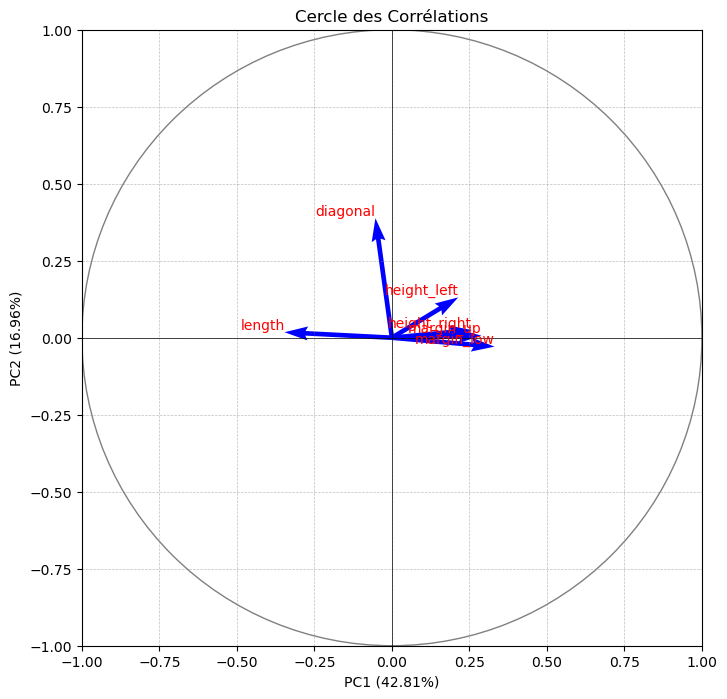

In [31]:
# sélection des variables pertinentes pour K-means
X_kmeans = billets[variables_kmeans]

# normalisation des données pour l'ACP
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_kmeans)

# on applique l'ACP avec 2 composantes principales
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# obtention des composantes principales
components = pd.DataFrame(pca.components_, columns=variables_kmeans)

# obtention des charges factorielles
factor_loadings = pd.DataFrame(pca.explained_variance_ratio_, columns=['Explained Variance'])
factor_loadings['Variable'] = variables_kmeans

# affichage des composantes et des charges
print("Composantes Principales :")
print(components)
print("\nCharges Factorielles :")
print(factor_loadings)

# calcul des coordonnées des variables sur les axes factoriels
coordinates = np.sqrt(pca.explained_variance_ratio_) * pca.components_.T

# on affiche le cercle des corrélations
circle = plt.Circle((0, 0), 1, color='grey', fill=False)
fig, ax = plt.subplots(figsize=(8, 8))
ax.add_artist(circle)

# affichage des coordonnées des variables sur le cercle
for i, (x, y) in enumerate(zip(coordinates[:, 0], coordinates[:, 1])):
    plt.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color='b')
    plt.text(x, y, variables_kmeans[i], ha='right', va='bottom', color='r')

# définition des limites du cercle
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.title('Cercle des Corrélations')
plt.xlabel(f'PC1 ({round(pca.explained_variance_ratio_[0]*100, 2)}%)')
plt.ylabel(f'PC2 ({round(pca.explained_variance_ratio_[1]*100, 2)}%)')

# on affiche le cercle
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

La première composante principale est <b>justifiée par toutes les variables, excepté la longueur du billet qui est anticorrelée, et par la diagonale qui n'a aucun impact</b>, mais qui est elle correlée fortement à la composante principale n°2.

### Clustering <a class="anchor" id="section_2_4_2"></a>

C:\Users\Avenmythril\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Avenmythril\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


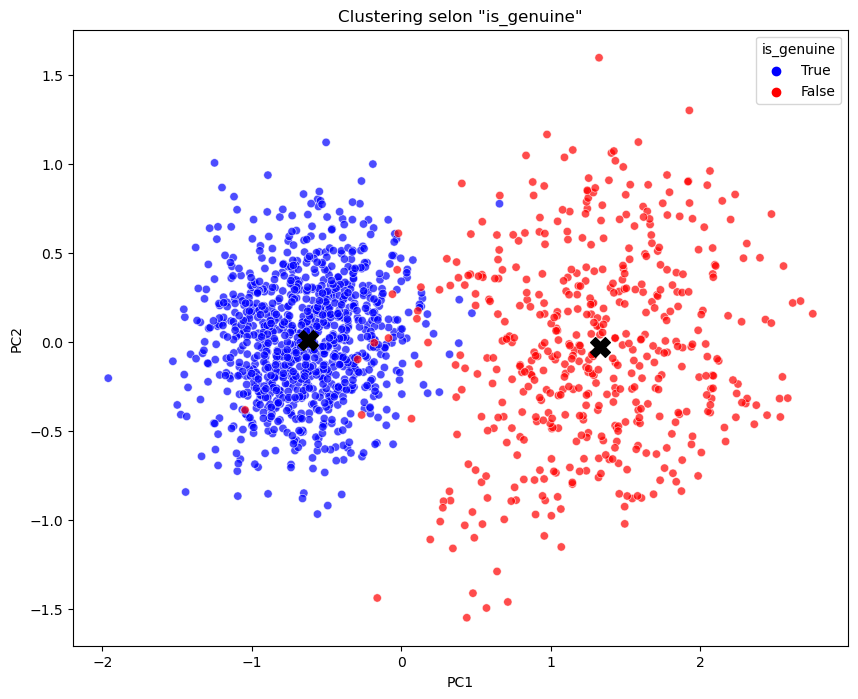

In [32]:
# données pour cluster
X = billets[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
y = billets['is_genuine']

# application de l'ACP
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# ajout des composantes principales au df
billets['PC1'] = X_pca[:, 0]
billets['PC2'] = X_pca[:, 1]

# ajout d'une colonne "Color" pour la couleur des points
billets['Color'] = billets['is_genuine'].apply(lambda x: 'True' if x else 'False')

# on trace le nuage de points
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Color', data=billets, palette=['blue', 'red'], alpha=0.7)

# ajout des étiquettes et titre
plt.title('Clustering selon "is_genuine"')
plt.xlabel('PC1')
plt.ylabel('PC2')

# légende
plt.legend(title='is_genuine')

# application de Kmeans pour les centroïdes
kmeans = KMeans(n_clusters=2)  # 2 clusters (hyperparamètre)
kmeans.fit(X)
centroids = pca.transform(kmeans.cluster_centers_)

# tracé des centroïdes
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='black', label='Centroids')

# affichage du nuage de points avec les centroïdes
plt.show()

Les deux clusters sont bien visibles. Cependant, quelques valeurs peuvent se confondre, à l'instar du point extrême gauche du cluster 2 (rouge).

### Analyse du pairplot <a class="anchor" id="section_2_4_3"></a>

C:\Users\Avenmythril\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


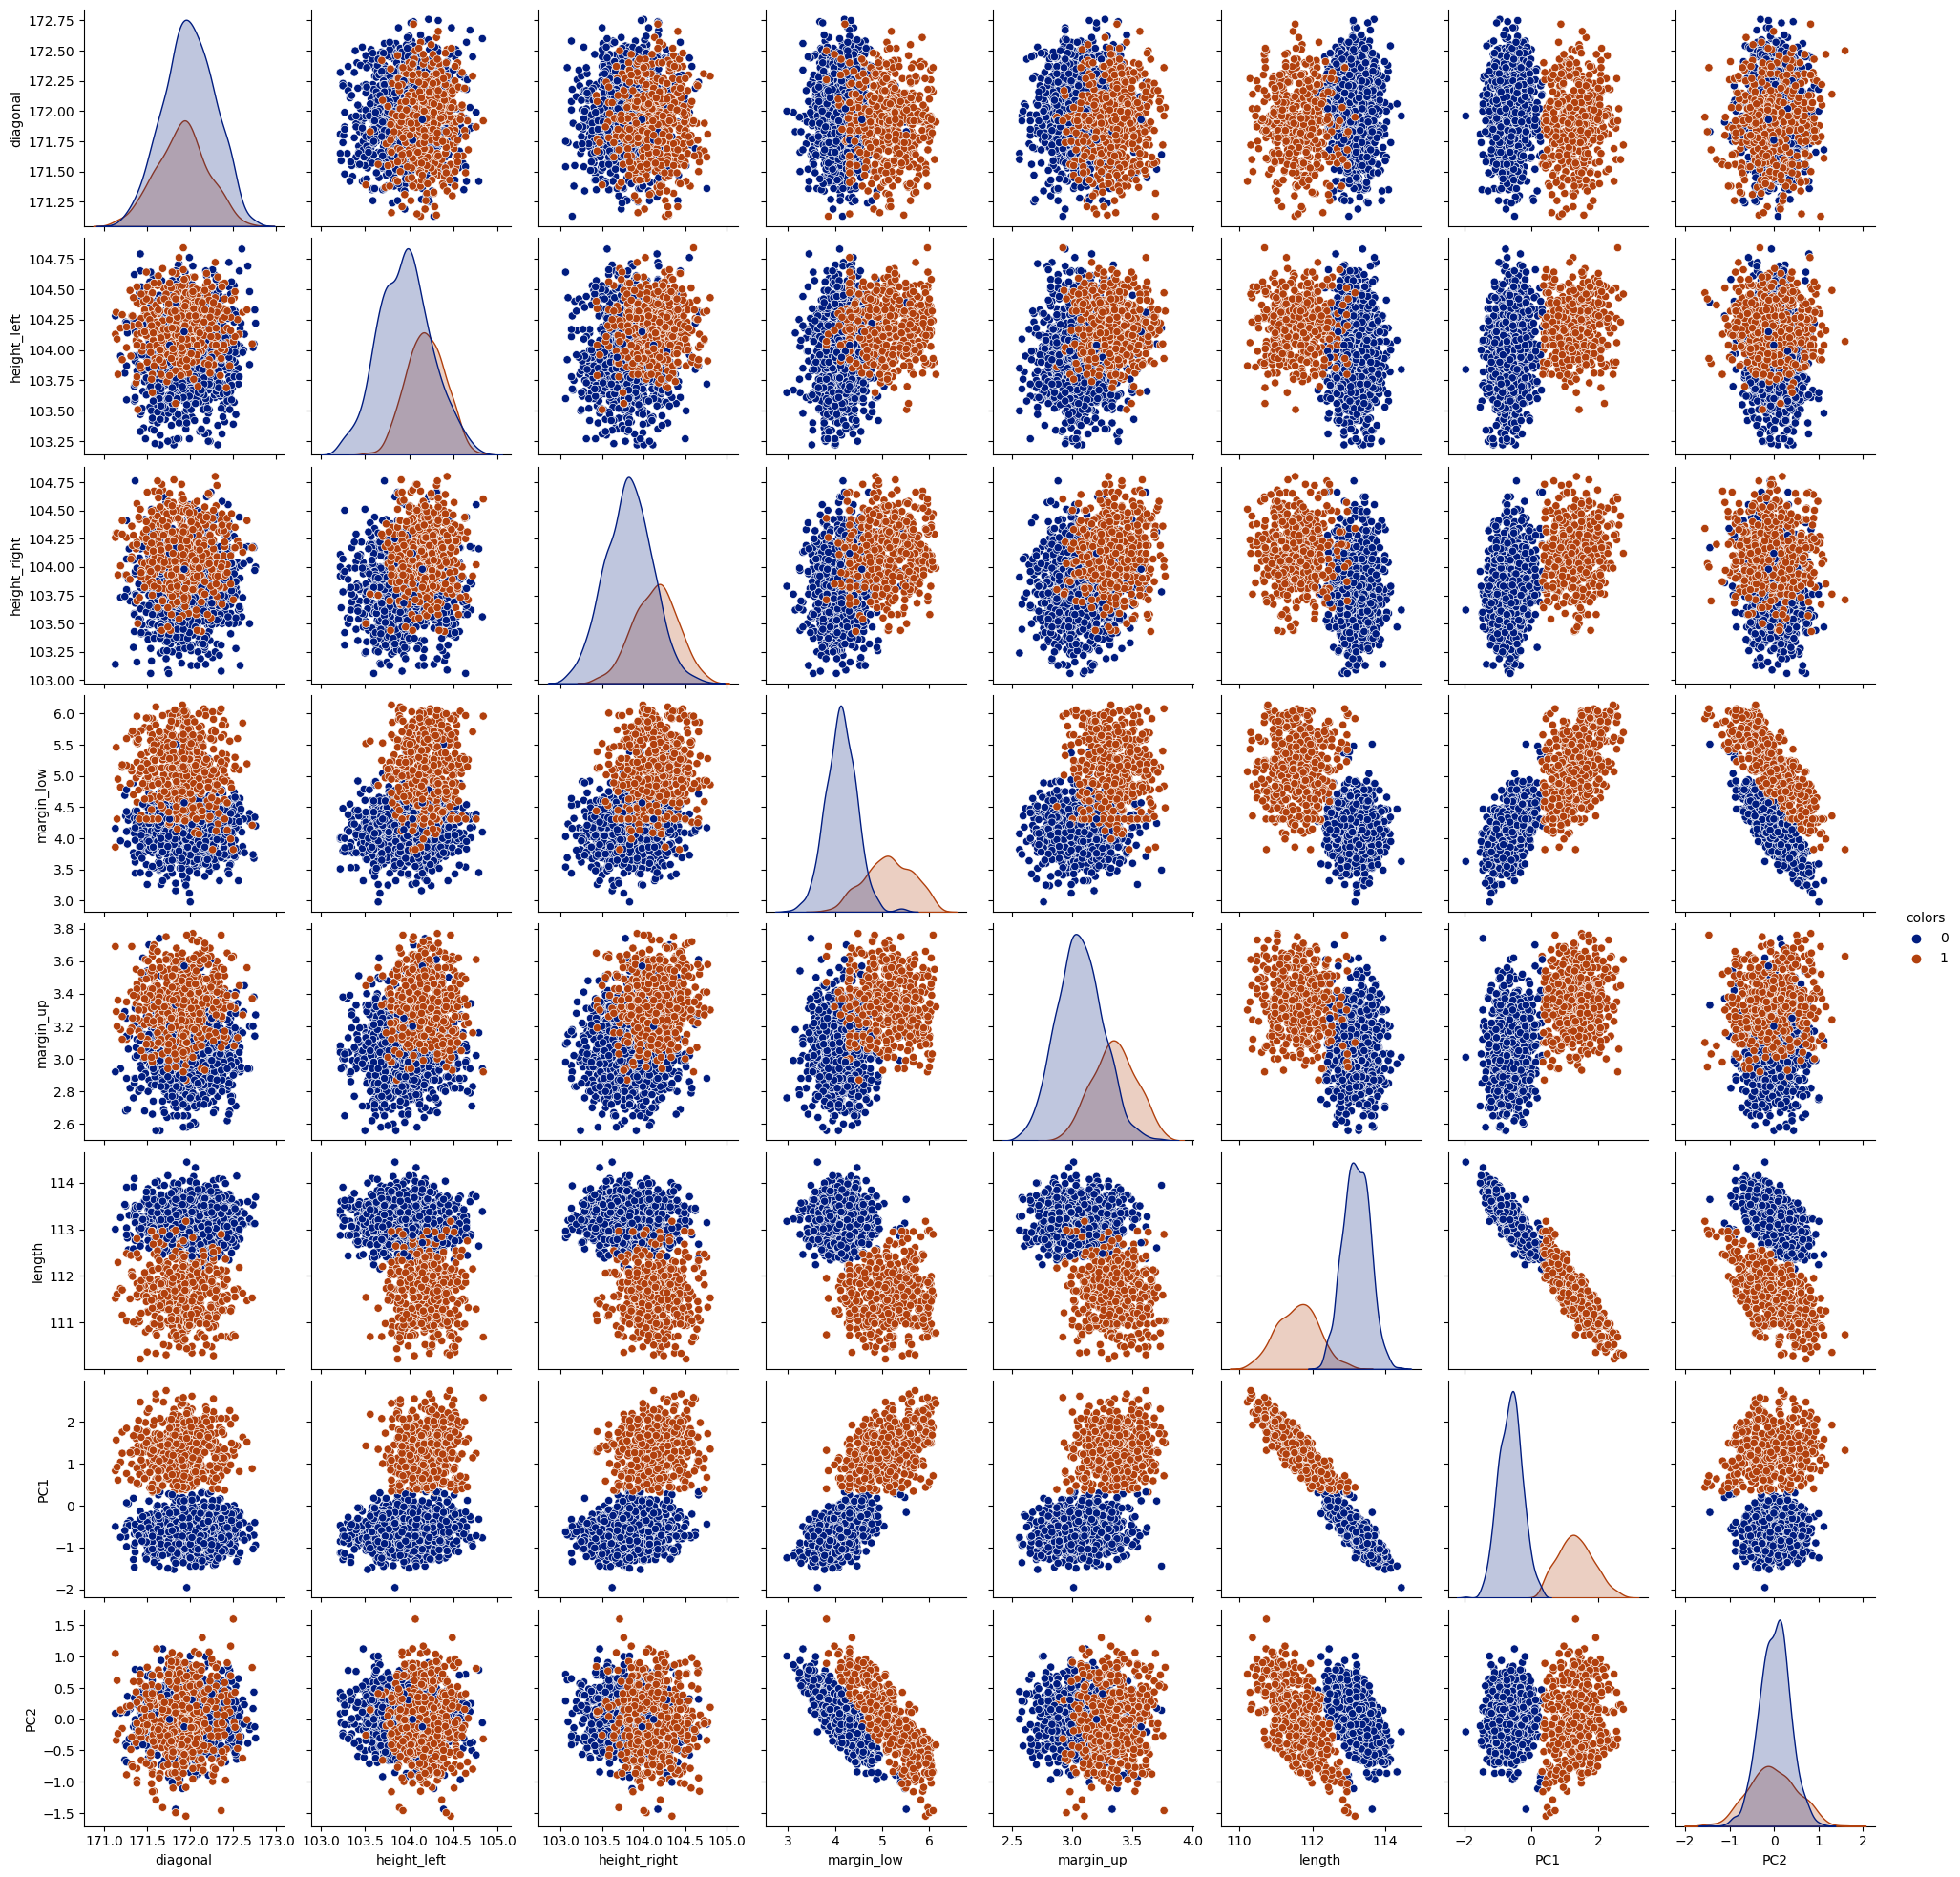

In [33]:
# on sélectionne les variables pertinentes pour l'analyse
variables_kmeans = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X_kmeans = billets[variables_kmeans]

# nombre de clusters
k = 2

# application de kmeans
kmeans = KMeans(n_clusters=k, random_state=42)
billets['colors'] = kmeans.fit_predict(X_kmeans)

# conversion de la colonne 'cluster' en numérique
billets['colors'] = pd.to_numeric(billets['colors'])

# visualisation des clusters (sauf 'is_genuine')
sns.pairplot(billets.drop(['is_genuine'], axis=1), hue='colors', palette='dark')
plt.show()

In [34]:
# suppression des colonnes qui ne nous serviront plus
billets = billets.drop(['PC1', 'PC2', 'Color', 'colors'], axis=1)
billets

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.04        103.92        4.52       2.89   
1           True    171.46       103.36        103.66        3.77       2.99   
2           True    172.69       104.48        103.50        4.40       2.94   
3           True    171.36       103.91        103.94        3.62       3.01   
4           True    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495       False    171.75       104.38        104.17        4.42       3.09   
1496       False    172.19       104.63        104.44        5.27       3.37   
1497       False    171.80       104.01        104.12        5.51       3.36   
1498       False    172.06       104.28        104.06        5.17       3.46   
1499       False    171.47       104.15        103.82        4.63       3.37   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1495  111.28  
1496  110.97  
1497  111.95  
1498  112.25  
1499  112.07  

[1500 rows x 7 columns]

### Modélisation prédictive par Kmeans <a class="anchor" id="section_2_4_4"></a>

In [35]:
# sélection des variables pertinentes
X_kmeans = billets[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
y_kmeans = billets['is_genuine']

# division des données en train et test
X_train_kmeans, X_test_kmeans, y_train_kmeans, y_test_kmeans = train_test_split(X_kmeans, y_kmeans, test_size=0.3, random_state=42)

# normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_kmeans)

# application de l'ACP avec 2 composantes
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# application de Kmeans sur l'ensemble d'entraînement
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_scaled)

# prédiction des clusters sur l'ensemble de test
X_test_scaled = scaler.transform(X_test_kmeans)
y_test_pred = kmeans.predict(X_test_scaled)

# inversion des étiquettes prédites (0 devient 1 et vice versa)
y_test_pred_inverted = 1 - y_test_pred

# création d'un df pour compararer les résultat avec l'inversion
comparison_df = pd.DataFrame({'is_genuine': y_test_kmeans, 'kmeans_labels': y_test_pred})

# affichage du Classification Report
print("Classification Report:")
print(classification_report(comparison_df['is_genuine'], comparison_df['kmeans_labels']))

# affichage de la Matrice de Confusion
print("\nConfusion Matrix:")
print(confusion_matrix(comparison_df['is_genuine'], comparison_df['kmeans_labels']))

# prédiction des clusters
X_test_scaled = scaler.transform(X_test_kmeans)
y_test_pred = kmeans.predict(X_test_scaled)

# inversion manuelle des prédictions (pour régler le souci des clusters)
y_test_pred = 1 - y_test_pred

# Création d'un DataFrame pour comparaison avec les véritables étiquettes
comparison_df = pd.DataFrame({'is_genuine': y_test_kmeans, 'kmeans_labels': y_test_pred})

# Affichage du Classification Report
print("Classification Report:")
print(classification_report(comparison_df['is_genuine'], comparison_df['kmeans_labels']))

# Affichage de la Matrice de Confusion
print("\nConfusion Matrix:")
print(confusion_matrix(comparison_df['is_genuine'], comparison_df['kmeans_labels']))

C:\Users\Avenmythril\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Avenmythril\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

       False       0.01      0.02      0.02       161
        True       0.02      0.01      0.02       289

    accuracy                           0.02       450
   macro avg       0.02      0.02      0.02       450
weighted avg       0.02      0.02      0.02       450


Confusion Matrix:
[[  4 157]
 [285   4]]
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.98      0.98       161
        True       0.99      0.99      0.99       289

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450


Confusion Matrix:
[[157   4]
 [  4 285]]


On ne fait pas de courbe ROC pour Kmeans, qui n'est pas un algorithme de modélisation de variables mais de clustering. Idem pour l'analyse de l'homosédasticité, distances de Cook, etc.

Les résultats sont bien plus encourageants que ceux de la régression liénaire, et <b>notre modèle indique 98% de précision générale!

## XGBoost <a class="anchor" id="section_2_5"></a>

### Modèle <a class="anchor" id="section_2_5_1"></a>

In [36]:
# on divise les variables indépendantes (X) et dépendantes (y)
X = billets.drop('is_genuine', axis=1)
y = billets['is_genuine']

# on divise les données en ensembles d'entraînement et de test (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# initialisation du modèle XGBoost
xgb_model = XGBClassifier(random_state=42)

# on entraîne le modèle sur l'ensemble d'entraînement
xgb_model.fit(X_train, y_train)

# prédiction des étiquettes sur l'ensemble de test
y_pred = xgb_model.predict(X_test)

# évaluation de la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# affichage des résultats
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

# validation croisée
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')

Accuracy: 0.9866666666666667
Confusion Matrix:
[[156   5]
 [  1 288]]
Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       161
        True       0.98      1.00      0.99       289

    accuracy                           0.99       450
   macro avg       0.99      0.98      0.99       450
weighted avg       0.99      0.99      0.99       450

Cross-Validation Scores: [0.98571429 0.98571429 0.98095238 0.98095238 0.99047619]
Mean CV Accuracy: 0.9847619047619048


Le XGboost révèle encore 5 faux positifs, ce qui est encore trop.

### Analyse des distances de Cook <a class="anchor" id="section_2_5_2"></a>

Distances de Cook pour chaque observation:
485     0.000492
527     0.000541
199     0.001559
889     0.000109
844     0.001858
          ...   
1130    0.006098
1294    0.001236
860     0.000372
1459    0.002496
1126    0.000142
Length: 1050, dtype: float64
Observations influentes:
Int64Index([1068, 1205, 1453, 1362, 1031, 1412,  946, 1388, 1075, 1024,  855,
            1486, 1223, 1245, 1244, 1087,  862, 1160, 1121, 1181, 1280, 1450,
            1429,  193, 1361, 1252, 1227, 1441, 1310, 1221,  341, 1347, 1089,
             191,  919,  728, 1403, 1407, 1015,  580, 1110, 1081,    4, 1115,
             920, 1062, 1426,   17,  980, 1314, 1226, 1409, 1472, 1378, 1270,
            1122,  197, 1372, 1331, 1254, 1383, 1109, 1376, 1017, 1367, 1413,
            1025, 1104,  897, 1154, 1267, 1082, 1482, 1130],
           dtype='int64')


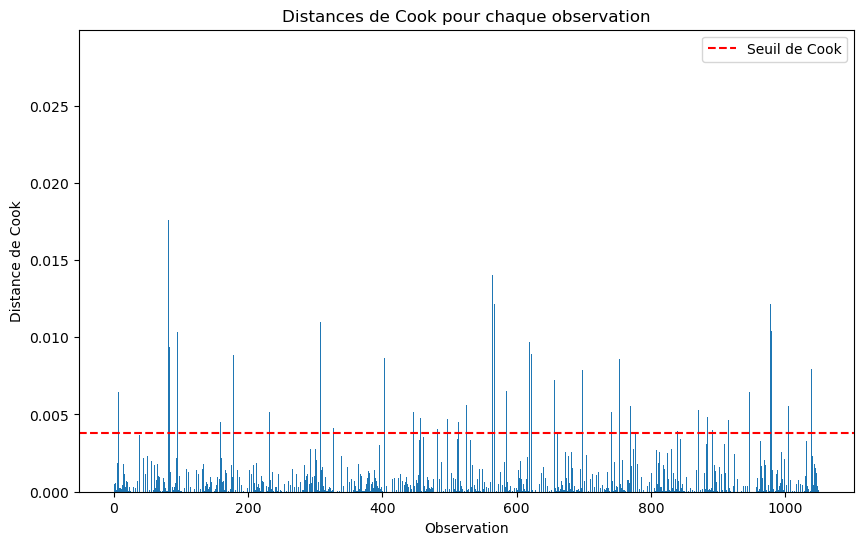

In [37]:
# on récupère les résidus et les leviers
influence = OLS(y_train, X_train).fit().get_influence().summary_frame()
leviers = influence['hat_diag']

# calcul des distances de Cook
n, p = X_train.shape
cooks_distances = influence['cooks_d'] * (p + 1) / (p * (1 - leviers))

# seuil de Cook pour identifier les observations influentes
seuil_dcook = 4 / (n - p)

# affichage des distances de Cook
print("Distances de Cook pour chaque observation:")
print(cooks_distances)

# identification des observations influentes
observations_influentes = cooks_distances[cooks_distances > seuil_dcook].index

# on affichage les observations influentes
print("Observations influentes:")
print(observations_influentes)

# graphique de Cook
plt.figure(figsize=(10, 6))
plt.bar(range(1, n + 1), cooks_distances)
plt.axhline(y=seuil_dcook, color='red', linestyle='--', label='Seuil de Cook')
plt.title("Distances de Cook pour chaque observation")
plt.xlabel("Observation")
plt.ylabel("Distance de Cook")
plt.legend()
plt.show()

Les résultats sont plus encourageants que l'analyse des résidus de la régression linéaire, avec une distance de Cook plus proche de la normale.

### Courbe ROC d'XGBoost <a class="anchor" id="section_2_5_3"></a>

La courbe ROC est utilisée pour évaluer la performance d'un modèle de classification binaire en termes de vrais positifs (sensibilité) et faux positifs (1 - spécificité). Cependant, la spécificité (taux de vrais négatifs) peut également être considérée en utilisant la courbe ROC.

En effet, on complète la courbe ROC avec une courbe de gain de spécificité, qui montre la relation entre la spécificité et la sensibilité pour différents seuils de classification, mais avec les faux négatifs.

On calculera également le taux de vrais négatifs (tnr) avec 1-(taux de faux positifs), ainsi que l'AUC (Area Under Curve) pour les deux courbes (ROC et gain de spécificité). Cela donnera une perspective plus complète de la performance du modèle, en tenant compte à la fois des vrais positifs et des vrais négatifs.

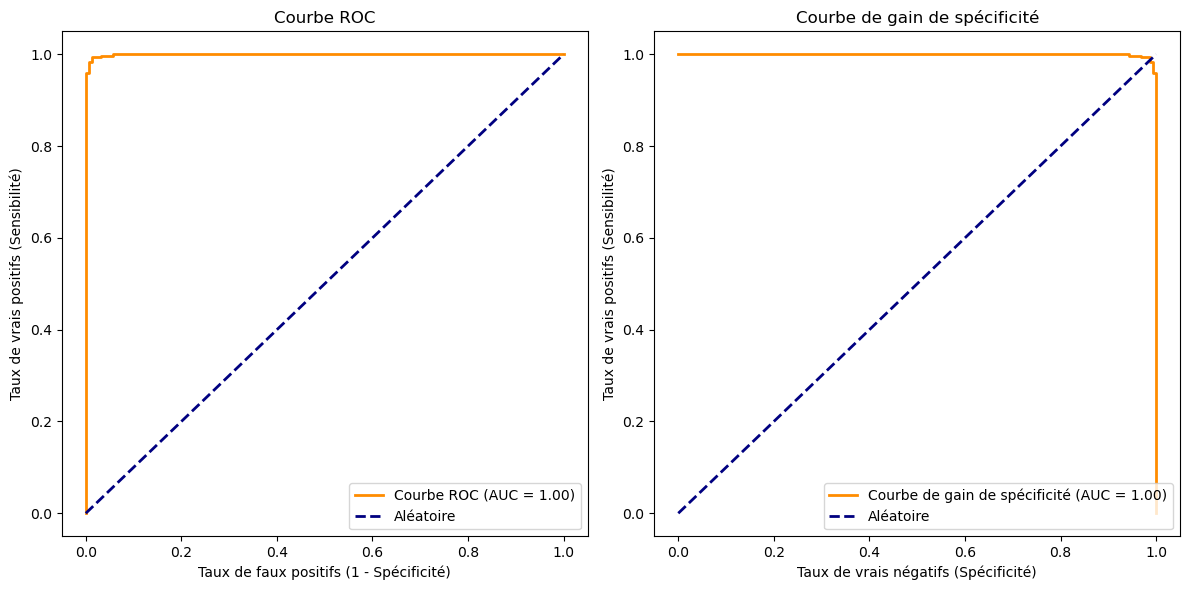

In [38]:
# on calcule les probabilités prédites pour la classe positive
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# calcul des courbes ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
tnr = 1 - fpr  # taux de vrais négatifs

# calcul de l'AUC pour les deux courbes
roc_auc = auc(fpr, tpr)
tnr_auc = auc(tnr, tpr)

# tracé des courbes ROC
plt.figure(figsize=(12, 6))

# visualisation de la courbe ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire')
plt.xlabel('Taux de faux positifs (1 - Spécificité)')
plt.ylabel('Taux de vrais positifs (Sensibilité)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')

# visualisation de la courbe de gain de spécificité
plt.subplot(1, 2, 2)
plt.plot(tnr, tpr, color='darkorange', lw=2, label='Courbe de gain de spécificité (AUC = {:.2f})'.format(tnr_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire')
plt.xlabel('Taux de vrais négatifs (Spécificité)')
plt.ylabel('Taux de vrais positifs (Sensibilité)')
plt.title('Courbe de gain de spécificité')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [39]:
# affichage des valeurs seuils de ROC
for fp, tp, th in zip(fpr, tpr, thresholds):
    print("fp : {} - tp : {} - seuil : {}".format(fp.round(2), tp.round(2), th.round(2)))

fp : 0.0 - tp : 0.0 - seuil : inf
fp : 0.0 - tp : 0.0 - seuil : 1.0
fp : 0.0 - tp : 0.01 - seuil : 1.0
fp : 0.0 - tp : 0.01 - seuil : 1.0
fp : 0.0 - tp : 0.03 - seuil : 1.0
fp : 0.0 - tp : 0.04 - seuil : 1.0
fp : 0.0 - tp : 0.04 - seuil : 1.0
fp : 0.0 - tp : 0.06 - seuil : 1.0
fp : 0.0 - tp : 0.06 - seuil : 1.0
fp : 0.0 - tp : 0.07 - seuil : 1.0
fp : 0.0 - tp : 0.1 - seuil : 1.0
fp : 0.0 - tp : 0.12 - seuil : 1.0
fp : 0.0 - tp : 0.12 - seuil : 1.0
fp : 0.0 - tp : 0.14 - seuil : 1.0
fp : 0.0 - tp : 0.17 - seuil : 1.0
fp : 0.0 - tp : 0.18 - seuil : 1.0
fp : 0.0 - tp : 0.18 - seuil : 1.0
fp : 0.0 - tp : 0.2 - seuil : 1.0
fp : 0.0 - tp : 0.21 - seuil : 1.0
fp : 0.0 - tp : 0.21 - seuil : 1.0
fp : 0.0 - tp : 0.22 - seuil : 1.0
fp : 0.0 - tp : 0.23 - seuil : 1.0
fp : 0.0 - tp : 0.24 - seuil : 1.0
fp : 0.0 - tp : 0.27 - seuil : 1.0
fp : 0.0 - tp : 0.28 - seuil : 1.0
fp : 0.0 - tp : 0.39 - seuil : 1.0
fp : 0.0 - tp : 0.39 - seuil : 1.0
fp : 0.0 - tp : 0.4 - seuil : 1.0
fp : 0.0 - tp : 0.41 - se

Un grand nombre de retours rend complexe la description:
- Les faux positifs (fp) oscillent entre 0 et 1, sans forcément se rapprocher plus d'une valeur que d'une autre.
- Les vrais positifs (tp) de même, bien qu'un plus grand nombre se rapproche de 1.
- le seuil oscille grandement aussi, donc tous les résultats ne sont pas certains.

## Régression logistique <a class="anchor" id="section_2_6"></a>

### Modèle <a class="anchor" id="section_2_6_1"></a>

Dernier modèle que nous allons faire tourner : la régression logistique. Nous pouvons supposer d'avance qu'il sera performant car il est optimisé pour travailler sur des valeurs binaires, comme c'est le cas pour notre colonne "is_genuine" qui régit notre fichier.

In [40]:
# initialisation du modèle de régression logistique
logreg_model = LogisticRegression()

# entraînement du modèle sur l'ensemble d'entraînement
logreg_model.fit(X_train, y_train)

# prédiction des étiquettes sur l'ensemble de test
y_pred = logreg_model.predict(X_test)

# test de modification d'hyperparamètres. résultats toujours <= à l'accuracy actuelle
# model = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=100)

# on évalue la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# affichage des résultats
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

# confirmation par validation croisée (ou cross-validation)
cv_scores = cross_val_score(logreg_model, X_train, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')

Accuracy: 0.9822222222222222
Confusion Matrix:
[[155   6]
 [  2 287]]
Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.96      0.97       161
        True       0.98      0.99      0.99       289

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450

Cross-Validation Scores: [0.98095238 0.98571429 0.98571429 0.99047619 0.99047619]
Mean CV Accuracy: 0.9866666666666667



Explication des résultats:
- L'accuracy (ou précision) est de 98%, ce qui confirme la stabilité du test. Les modifications hyperparamétriques ne permettent pas de monter encore plus haut.
- La "Matrice de confustion" nous informe que 155 vrais billets et 287 faux ont été détectés comme tels. Seuls 6 vrais ont été étiquettés "faux négatif", et 2 faux est vu comme "faux positif".

Le <b>rapport de classification </b> confirme ce résultat.

Afin de s'assurer de la qualité du modèle, nous allons effectuer une analyse de la courbe ROC (le modèle de régression logistique ne permettant pas une visualisation propre de l'homosédasticité).

### Courbe ROC de régression logistique <a class="anchor" id="section_2_6_2"></a>

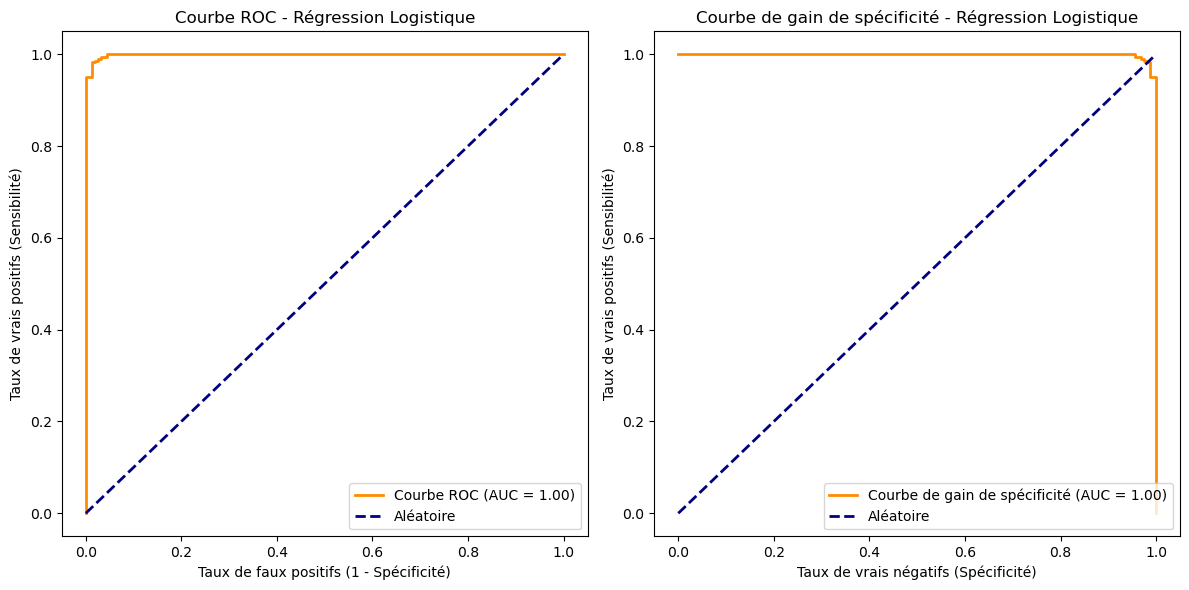

In [41]:
# probabilités prédites pour la classe positive - Régression Logistique
y_prob_logistic = logreg_model.predict_proba(X_test)[:, 1]

# calcul de ROC
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test, y_prob_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# calcul de la spécificité
specificity_logistic = 1 - fpr_logistic

# calcul de la courbe de gain de spécificité
plt.figure(figsize=(12, 6))

# visualisation de la courbe ROC
plt.subplot(1, 2, 1)
plt.plot(fpr_logistic, tpr_logistic, color='darkorange', lw=2, label='Courbe ROC (AUC = {:.2f})'.format(roc_auc_logistic))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire')
plt.xlabel('Taux de faux positifs (1 - Spécificité)')
plt.ylabel('Taux de vrais positifs (Sensibilité)')
plt.title('Courbe ROC - Régression Logistique')
plt.legend(loc='lower right')

# visualisation de la courbe de gain de spécificité
plt.subplot(1, 2, 2)
plt.plot(specificity_logistic, tpr_logistic, color='darkorange', lw=2, label='Courbe de gain de spécificité (AUC = {:.2f})'.format(roc_auc_logistic))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire')
plt.xlabel('Taux de vrais négatifs (Spécificité)')
plt.ylabel('Taux de vrais positifs (Sensibilité)')
plt.title('Courbe de gain de spécificité - Régression Logistique')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [42]:
# Calculez la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logistic)

# Calculez l'aire sous la courbe ROC (AUC)
roc_auc_logistic = auc(fpr, tpr)

for fp, tp, th in zip(fpr, tpr, thresholds):
    print("fp : {} - tp : {} - seuil : {}".format(fp.round(2), tp.round(2), th.round(2)))

fp : 0.0 - tp : 0.0 - seuil : inf
fp : 0.0 - tp : 0.0 - seuil : 1.0
fp : 0.0 - tp : 0.95 - seuil : 0.91
fp : 0.01 - tp : 0.95 - seuil : 0.91
fp : 0.01 - tp : 0.98 - seuil : 0.83
fp : 0.02 - tp : 0.98 - seuil : 0.82
fp : 0.02 - tp : 0.99 - seuil : 0.81
fp : 0.02 - tp : 0.99 - seuil : 0.8
fp : 0.02 - tp : 0.99 - seuil : 0.74
fp : 0.03 - tp : 0.99 - seuil : 0.72
fp : 0.03 - tp : 0.99 - seuil : 0.59
fp : 0.04 - tp : 0.99 - seuil : 0.48
fp : 0.04 - tp : 1.0 - seuil : 0.37
fp : 1.0 - tp : 1.0 - seuil : 0.0


Ces résultats sont très encourageants car ils indiquent une performance presque parfaite :
- des seuils élevés qui dénotent d'une grande certitude de prédiction
- des taux de faux positifs nuls avec un fp proche de 0
- des taux de vrai positifs élevés avec des tp proches de 1

Et surtout : un nombre de lignes bien moindre que pour XGBoost, ce qui reflète une différence non négligeable dans la manière d'appréhender la distribution des probabilités entre les deux modèles.

# Modèle final <a class="anchor" id="chapter3"></a>

Puisque plusieurs algorithmes ont révélé un résultat proche de 100% mais potentiellement différents, il sera intéressant d'entrainer les futures données sur 3 modèles et de comparer les résultats à chaque fois. On retiendra :
- Le modèle de clustering <b>Kmeans
- Le modèle robuste (si le fichier n'est pas trop grand) <b>XGBoost
- Le modèle binaire de <b>Régression Logistique.
    
Comme on dit, "Jamais 2 sans 3"!

In [55]:
# import des données d'entrainement et head/tail
billets_prod = pd.read_csv (r'C:\Users\Avenmythril\Desktop\Formations\DAn\Projet 10 - Python machine learning\test_P10.csv')
billets_prod

diagonal  height_left  height_right  margin_low  margin_up  length   id
0    172.09       103.95        103.73        4.39       3.09  113.19  B_1
1    171.52       104.17        104.03        5.27       3.16  111.82  B_2
2    171.78       103.80        103.75        3.81       3.24  113.39  B_3
3    172.02       104.08        103.99        5.57       3.30  111.10  B_4
4    171.79       104.34        104.37        5.00       3.07  111.87  B_5

In [56]:
# XGBoost
X_new_xgb = billets_prod.drop('id', axis=1)  # Assurez-vous que les colonnes correspondent
predictions_xgb = xgb_model.predict(X_new_xgb)

# KMeans
X_new_kmeans = billets_prod.drop('id', axis=1)  # Assurez-vous que les colonnes correspondent
X_new_kmeans_scaled = scaler.transform(X_new_kmeans)
predictions_kmeans = kmeans.predict(X_new_kmeans_scaled)
# inversion des prédictions
predictions_kmeans = 1 - predictions_kmeans

# Régression logistique
X_new_logreg = billets_prod.drop('id', axis=1)  # Assurez-vous que les colonnes correspondent
predictions_logreg = logreg_model.predict(X_new_logreg)

In [57]:
# impression du df true/false
result_df = pd.DataFrame({
    'id': billets_prod['id'],
    'predictions_xgb': predictions_xgb,
    'predictions_kmeans': predictions_kmeans,
    'predictions_logreg': predictions_logreg
})

result_df

id  predictions_xgb  predictions_kmeans  predictions_logreg
0  B_1                1                   1                True
1  B_2                0                   0               False
2  B_3                1                   1                True
3  B_4                0                   0               False
4  B_5                0                   0               False

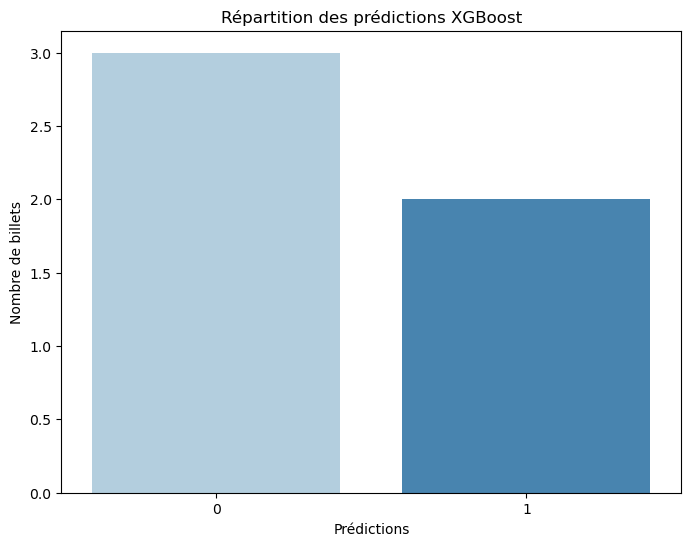

In [58]:
# comptage des prédictions XGBoost
xgb_counts = result_df['predictions_xgb'].value_counts()

# tracé du barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=xgb_counts.index, y=xgb_counts.values, palette="Blues")
plt.title('Répartition des prédictions XGBoost')
plt.xlabel('Prédictions')
plt.ylabel('Nombre de billets')
plt.show()

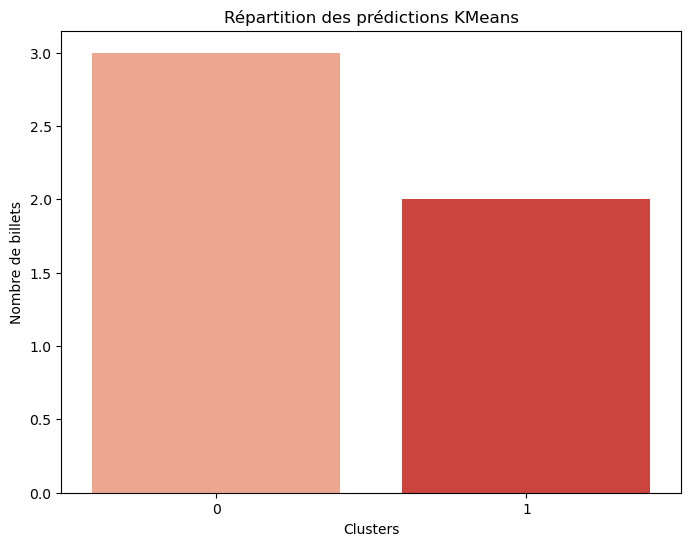

In [59]:
# comptage des prédictions KMeans
kmeans_counts = result_df['predictions_kmeans'].value_counts()

# tracé du barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=kmeans_counts.index, y=kmeans_counts.values, palette="Reds")
plt.title('Répartition des prédictions KMeans')
plt.xlabel('Clusters')
plt.ylabel('Nombre de billets')
plt.show()

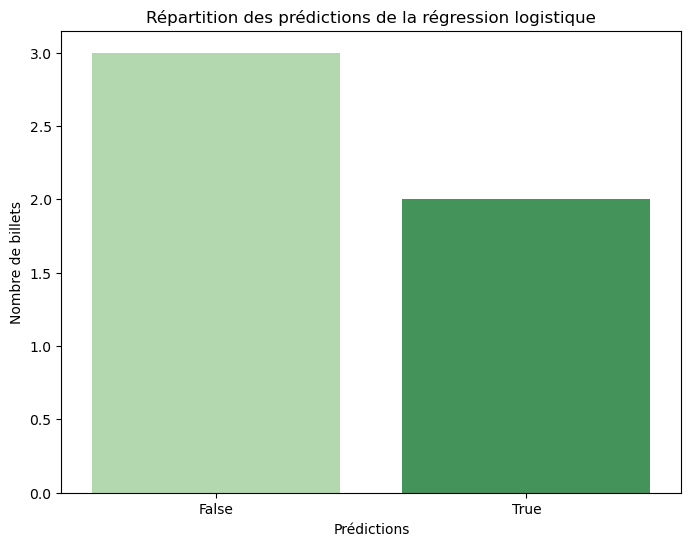

In [60]:
# comptage des prédictions de la régression logistique
logreg_counts = result_df['predictions_logreg'].value_counts()

# tracé du barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=logreg_counts.index, y=logreg_counts.values, palette="Greens")
plt.title('Répartition des prédictions de la régression logistique')
plt.xlabel('Prédictions')
plt.ylabel('Nombre de billets')
plt.show()